In [ ]:
pip install tensorflow numpy pandas opencv-python scikit-learn matplotlib seaborn


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from scipy.stats import mode
from sklearn.utils.class_weight import compute_class_weight


In [ ]:

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Define Dataset Paths
drive_path = "/content/drive/MyDrive"
train_data_dir = os.path.join(drive_path, "rice-disease-classification.v1i.folder/train")
valid_data_dir = os.path.join(drive_path, "rice-disease-classification.v1i.folder/valid")
test_data_dir = os.path.join(drive_path, "rice-disease-classification.v1i.folder/test")
soil_data_dir = os.path.join(drive_path, "soil_new")


Mounted at /content/drive


In [ ]:
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive"
rice_data_dir = os.path.join(drive_path, "Soil Moisture.v1i.folder")
soil_data_dir = os.path.join(drive_path, "soil_new")

# Define dataset paths
train_data_dir = "/content/drive/MyDrive/rice-disease-classification.v1i.folder/train"
valid_data_dir = "/content/drive/MyDrive/rice-disease-classification.v1i.folder/valid"
test_data_dir = "/content/drive/MyDrive/rice-disease-classification.v1i.folder/test"

# Check if dataset directories exist
if not os.path.exists(train_data_dir) or not os.path.exists(valid_data_dir) or not os.path.exists(test_data_dir):
    raise FileNotFoundError("Error: One or more dataset directories not found!")

# Define class names
rice_classes = ["blast", "blight", "healthy_rice_plant", "tungro"]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# ✅ Verify Dataset Paths
for path in [train_data_dir, valid_data_dir, test_data_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Error: Dataset directory '{path}' not found!")

# ✅ Define Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)


train_generator = datagen.flow_from_directory(train_data_dir, target_size=(128, 128), batch_size=16, class_mode="sparse")
val_generator = datagen.flow_from_directory(valid_data_dir, target_size=(128, 128), batch_size=16, class_mode="sparse")

print("✅ Dataset Loaded Successfully")

Found 2956 images belonging to 4 classes.
Found 359 images belonging to 4 classes.
✅ Dataset Loaded Successfully


In [ ]:
# ✅ Convert ImageDataGenerator to NumPy Arrays
def generator_to_numpy(generator):
    images, labels = [], []
    for i in range(len(generator)):
        batch = generator[i]
        images.append(batch[0])
        labels.append(batch[1])
    return np.concatenate(images), np.concatenate(labels)

X_train_rice, y_train_rice = generator_to_numpy(train_generator)
X_val_rice, y_val_rice = generator_to_numpy(val_generator)

print("✅ Data Converted to NumPy Arrays")


✅ Data Converted to NumPy Arrays


In [ ]:

# ✅ Define Data Paths
soil_data_dir = "/content/drive/MyDrive/soil_new"
weather_file = os.path.join(soil_data_dir, "03.Weather_Station_1_and_2", "Weather_Station_1.csv")
soil_file = os.path.join(soil_data_dir, "02.Soil_Sensing_LoRa_Node_Farmer_3", "Soil_Sensing_LoRa_Node_Farmer_3_Corn.csv")

# ✅ Ensure Data Exists
if not os.path.exists(weather_file):
    raise FileNotFoundError(f"Error: Weather data file '{weather_file}' not found!")
if not os.path.exists(soil_file):
    raise FileNotFoundError(f"Error: Soil data file '{soil_file}' not found!")

# ✅ Load Data
weather_data = pd.read_csv(weather_file)
soil_data = pd.read_csv(soil_file)

# ✅ Convert Time Columns to Datetime Format
weather_data['observation_time'] = pd.to_datetime(weather_data['observation_time']).dt.tz_localize(None)
soil_data['time'] = pd.to_datetime(soil_data['time']).dt.tz_localize(None)

# ✅ Define Feature Sets (Ensure They Match Column Names)
weather_features = ['humidity', 'rain', 'temperature', 'wind_speed_mph']
soil_features = ['soil_sensor1_temp', 'soil_sensor2_temp', 'soil_sensor1_conductivity',
                 'soil_sensor2_conductivity', 'soil_sensor1_vwc', 'soil_sensor2_vwc']

# ✅ Select Required Columns Only
weather_data = weather_data[['observation_time'] + weather_features]
soil_data = soil_data[['time'] + soil_features]

# ✅ Merge Data (Handling Datetime Columns Correctly)
merged_data = pd.merge_asof(
    soil_data.sort_values(by="time"),
    weather_data.sort_values(by="observation_time"),
    left_on="time",
    right_on="observation_time"
).drop(columns=['observation_time', 'time'])  # Remove unneeded columns

# ✅ Handle Missing Values
imputer = SimpleImputer(strategy='mean')
merged_data[weather_features + soil_features] = imputer.fit_transform(merged_data[weather_features + soil_features])

# ✅ Apply MinMax Scaling (0 to 1) Instead of StandardScaler()
scaler = MinMaxScaler()
merged_data[weather_features + soil_features] = scaler.fit_transform(
    merged_data[weather_features + soil_features]
)

# ✅ Print Confirmation & Check Data Sample
print("✅ Data Successfully Processed")
print("🔍 Merged Data Sample:")
print(merged_data.head())

# ✅ Check if Data is Normalized (All Values Should Be Between 0 & 1)
print("\n📊 Data Summary After Scaling:")
print(merged_data.describe())


✅ Data Successfully Processed
🔍 Merged Data Sample:
   soil_sensor1_temp  soil_sensor2_temp  soil_sensor1_conductivity  \
0           0.002085           0.001600                   0.002354   
1           0.002085           0.001616                   0.002354   
2           0.002069           0.001632                   0.002354   
3           0.002069           0.001632                   0.002339   
4           0.002053           0.001649                   0.002339   

   soil_sensor2_conductivity  soil_sensor1_vwc  soil_sensor2_vwc  humidity  \
0                   0.002828          0.393535          0.380709  0.698133   
1                   0.002843          0.393535          0.380709  0.698133   
2                   0.002828          0.393535          0.380709  0.698133   
3                   0.002828          0.393535          0.380709  0.698133   
4                   0.002828          0.393535          0.380709  0.698133   

       rain  temperature  wind_speed_mph  
0  0.003457    

In [ ]:
print("Rice Image Labels Size:", len(y_train_rice))
print("Soil & Weather Data Size:", len(merged_data))


Rice Image Labels Size: 2956
Soil & Weather Data Size: 6281


In [ ]:
merged_data = merged_data.iloc[:len(y_train_rice)]  # Keep only matching samples


In [ ]:
print("✅ Data after alignment")
print("Rice Labels:", len(y_train_rice))
print("Soil & Weather Data:", len(merged_data))


✅ Data after alignment
Rice Labels: 2956
Soil & Weather Data: 2956


In [ ]:
X_soil_train, X_soil_val, y_train_soil, y_val_soil = train_test_split(
    merged_data, y_train_rice, test_size=0.2, random_state=42, stratify=y_train_rice
)


In [ ]:
# Define class labels
rice_classes = ["blast", "blight", "healthy_rice_plant", "tungro"]

# ✅ EfficientNetB0 Model for Image Feature Extraction
image_input = Input(shape=(128, 128, 3))
efficientnet = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=image_input)

# Unfreeze deeper layers of EfficientNet for fine-tuning
efficientnet.trainable = True  # Allow training on EfficientNet's deeper layers

x = GlobalAveragePooling2D()(efficientnet.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Increased neurons
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)



# ✅ Soil & Weather Data Model
soil_input = Input(shape=(X_soil_train.shape[1],))
y = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(soil_input)  # Increased neurons
y = BatchNormalization()(y)
y = Dropout(0.4)(y)
y = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(y)
y = BatchNormalization()(y)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(y)
y = BatchNormalization()(y)
y = Dropout(0.3)(y)

# ✅ Merge Image & Soil Models
merged = Concatenate()([x, y])
merged = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.4)(merged)
merged = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.3)(merged)
output = Dense(len(rice_classes), activation='softmax')(merged)

# ✅ Compile Model with Lower Learning Rate
model = Model(inputs=[image_input, soil_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
print("X_train_rice shape:", X_train_rice.shape)
print("X_soil_train shape:", X_soil_train.shape)
print("y_train_rice shape:", y_train_rice.shape)

print("X_val_rice shape:", X_val_rice.shape)
print("X_soil_val shape:", X_soil_val.shape)
print("y_val_rice shape:", y_val_rice.shape)


X_train_rice shape: (2956, 128, 128, 3)
X_soil_train shape: (2364, 10)
y_train_rice shape: (2956,)
X_val_rice shape: (359, 128, 128, 3)
X_soil_val shape: (592, 10)
y_val_rice shape: (359,)


In [ ]:
# Ensure both inputs have the same number of samples
min_samples = min(len(X_train_rice), len(X_soil_train))

X_train_rice = X_train_rice[:min_samples]
X_soil_train = X_soil_train[:min_samples]
y_train_rice = y_train_rice[:min_samples]

# Do the same for validation sets
min_samples_val = min(len(X_val_rice), len(X_soil_val))

X_val_rice = X_val_rice[:min_samples_val]
X_soil_val = X_soil_val[:min_samples_val]
y_val_rice = y_val_rice[:min_samples_val]


In [ ]:
print("After fixing:")
print("X_train_rice shape:", X_train_rice.shape)
print("X_soil_train shape:", X_soil_train.shape)
print("y_train_rice shape:", y_train_rice.shape)


After fixing:
X_train_rice shape: (2364, 128, 128, 3)
X_soil_train shape: (2364, 10)
y_train_rice shape: (2364,)


In [ ]:
# ✅ Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

# ✅ Train Model with Callbacks
history = model.fit(
    [X_train_rice, X_soil_train], y_train_rice,
    validation_data=([X_val_rice, X_soil_val], y_val_rice),
    epochs=30,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

print("✅ Model Training Completed!")


Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 157s 423ms/step - accuracy: 0.3385 - loss: 3.6803 - val_accuracy: 0.7716 - val_loss: 2.3986 - learning_rate: 5.0000e-04
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7309 - loss: 2.5802 - val_accuracy: 0.9164 - val_loss: 2.0572 - learning_rate: 5.0000e-04
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8821 - loss: 2.1893 - val_accuracy: 0.9638 - val_loss: 1.9282 - learning_rate: 5.0000e-04
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9250 - loss: 2.0932 - val_accuracy: 0.9805 - val_loss: 1.8640 - learning_rate: 5.0000e-04
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9277 - loss: 2.0176 - val_accuracy: 0.9972 - val_loss: 1.8048 - learning_rate: 5.0000e-04
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9481 - loss: 1.9504 - val_accuracy: 0.9833 - val_loss: 1.7838 - learning_rate: 5.0000e-04
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/ste

In [ ]:

# ✅ Define Dataset Paths
drive_path = "/content/drive/MyDrive"
test_data_dir = os.path.join(drive_path, "rice-disease-classification.v1i.folder/test")

# ✅ Check If Test Dataset Exists
if not os.path.exists(test_data_dir):
    raise FileNotFoundError(f"Error: Test dataset directory '{test_data_dir}' not found!")

# ✅ Function to Select a Random Image from a Random Class
def find_random_image_balanced(root_folder):
    class_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    if not class_folders:
        raise FileNotFoundError("No class folders found in the dataset!")

    selected_class = random.choice(class_folders)
    class_path = os.path.join(root_folder, selected_class)

    image_paths = [os.path.join(class_path, f) for f in os.listdir(class_path)
                   if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff"))]

    if not image_paths:
        raise FileNotFoundError(f"No images found in the selected class: {selected_class}")

    selected_image = random.choice(image_paths)
    return selected_image, selected_class

# ✅ Select a Test Image Using Balanced Sampling
test_image_path, selected_class = find_random_image_balanced(test_data_dir)

if test_image_path:
    print(f"Selected Test Image: {test_image_path} (Class: {selected_class})")
else:
    raise FileNotFoundError("No images found in the dataset!")

# ✅ Load Corresponding Soil & Weather Data
if 'merged_data' in globals():
    selected_index = random.randint(0, len(merged_data) - 1)
    sample_soil_data = merged_data.iloc[selected_index]
    print("Correctly Mapped Soil & Weather Data Loaded")
else:
    raise NameError("Error: 'merged_data' not defined. Ensure soil & weather data is loaded.")

# ✅ Function to Preprocess Image (Ensuring Consistency with Training)
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

Selected Test Image: /content/drive/MyDrive/rice-disease-classification.v1i.folder/test/blast/BLAST8_127_JPG.rf.c1dfeddb6fdb5c6ba70a815520c1ae2b.jpg (Class: blast)
Correctly Mapped Soil & Weather Data Loaded


In [ ]:
# ✅ Risk Assessment Function
def risk_alert(sensor_data, disease_prediction):
    disease_classes = ["Blast", "Blight", "Healthy", "Tungro"]
    predicted_disease = disease_classes[disease_prediction]

    # Extract soil and weather conditions
    moisture_level = sensor_data['soil_sensor1_vwc']
    soil_temp = sensor_data['soil_sensor1_temp']
    conductivity = sensor_data['soil_sensor1_conductivity']
    air_temp = sensor_data['temperature']
    humidity = sensor_data['humidity']
    wind_speed = sensor_data['wind_speed_mph']

    # ✅ Multi-Condition Risk Assessment
    if moisture_level > 0.8 and predicted_disease in ["Blast", "Blight"]:
        return f"High Risk: {predicted_disease} detected! Wet soil increases fungal infection risk."

    elif air_temp > 35 and predicted_disease == "Tungro":
        return f"Warning: {predicted_disease} detected! High temperatures increase virus transmission risk."

    elif wind_speed > 20 and predicted_disease in ["Blast", "Blight"]:
        return f"Caution: {predicted_disease} detected! High wind speeds may spread disease faster."

    elif conductivity < 0.2:
        return f"Moderate Risk: {predicted_disease} detected! Low soil conductivity may affect plant growth."

    elif humidity > 85:
        return f"High Risk: {predicted_disease} detected! High humidity creates a favorable environment for disease spread."

    else:
        return "Stable Condition."


In [ ]:

# ✅ Function to Predict Disease
def predict_disease(image_path, soil_data):
    # Load and preprocess the test image
    img_array = preprocess_image(image_path)

    # Extract true label from filename
    true_label = image_path.split("/")[-2]

    # Make prediction
    predictions = model.predict([img_array, soil_data.values.reshape(1, -1)])
    predicted_label_index = np.argmax(predictions)
    predicted_label = rice_classes[predicted_label_index]

    # Compare True vs. Predicted Label
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")

    if true_label.lower() != predicted_label.lower():
        print("Warning: Model misclassified this image!")
    else:
        print("Prediction matches actual label.")

    # Print soil/weather details
    print("\nSoil & Weather Condition Details:")
    print(f"Soil Moisture: {soil_data['soil_sensor1_vwc']:.2f}")
    print(f"Soil Temperature: {soil_data['soil_sensor1_temp']:.2f}°C")
    print(f"Soil Conductivity: {soil_data['soil_sensor1_conductivity']:.2f}")
    print(f"Humidity: {soil_data['humidity']:.2f}%")
    print(f"Wind Speed: {soil_data['wind_speed_mph']:.2f} mph")
    print(f"Air Temperature: {soil_data['temperature']:.2f}°C")

    # Get risk assessment inside the function
    risk_message = risk_alert(soil_data, predicted_label_index)
    print("\nRisk Assessment:")
    print(risk_message)

    return predicted_label, risk_message

# ✅ Call the Function
predicted_label, risk_message = predict_disease(test_image_path, sample_soil_data)

# ✅ Compute Predictions on Validation Data
y_pred_prob = model.predict([X_val_rice, X_soil_val])
y_pred = np.argmax(y_pred_prob, axis=1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
True Label: blast
Predicted Label: blast
Prediction matches actual label.

Soil & Weather Condition Details:
Soil Moisture: 0.39
Soil Temperature: 0.00°C
Soil Conductivity: 0.00
Humidity: 0.64%
Wind Speed: 0.26 mph
Air Temperature: 0.65°C

Risk Assessment:
Moderate Risk: Blast detected! Low soil conductivity may affect plant growth.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

📊 Improved Classification Report:

                    precision    recall  f1-score   support

             blast       0.95      1.00      0.98       105
            blight       1.00      0.96      0.98       133
healthy_rice_plant       1.00      1.00      1.00        10
            tungro       1.00      1.00      1.00       111

          accuracy                           0.99       359
         macro avg       0.99      0.99      0.99       359
      weighted avg       0.99      0.99      0.99       359



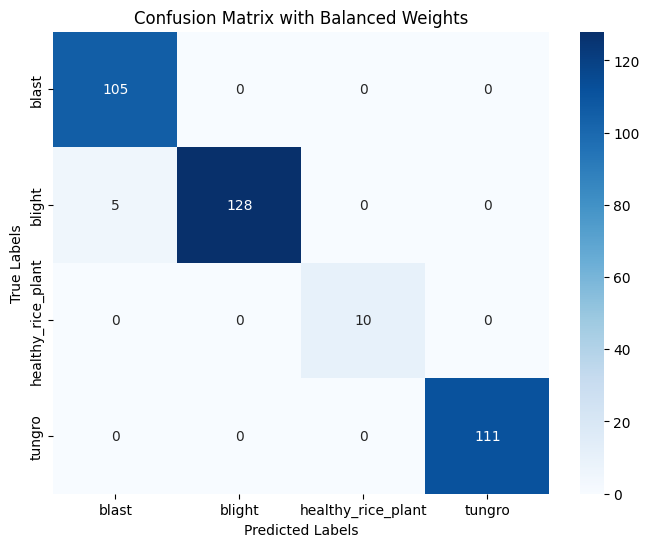

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import mode
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files

# ✅ Compute Class Weights to Handle Imbalance
class_weights = compute_class_weight("balanced", classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# ✅ Make Predictions Using Model
y_pred_prob = model.predict([X_val_rice, X_soil_val])

# ✅ Apply a Softmax Threshold for More Confident Predictions
threshold = 0.6  # Adjust for better classification
y_pred = np.where(y_pred_prob.max(axis=1) > threshold, np.argmax(y_pred_prob, axis=1), -1)

# ✅ Compute mode safely to avoid IndexError
most_common_class = mode(y_train_rice, keepdims=True).mode
most_common_class = most_common_class[0] if isinstance(most_common_class, np.ndarray) else most_common_class

# ✅ Replace -1 (low-confidence predictions) with the most common class
y_pred = np.where(y_pred == -1, most_common_class, y_pred)

# ✅ Print Improved Classification Report
print("\n📊 Improved Classification Report:\n")
print(classification_report(y_val_rice, y_pred, target_names=rice_classes))

# ✅ Generate & Display Confusion Matrix with Balanced Weights
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_val_rice, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rice_classes, yticklabels=rice_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix with Balanced Weights")

# ✅ Save Confusion Matrix Correctly Before Downloading
confusion_matrix_path = "confusion_matrix.png"
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

# ✅ Ensure File Exists Before Downloading
files.download(confusion_matrix_path)


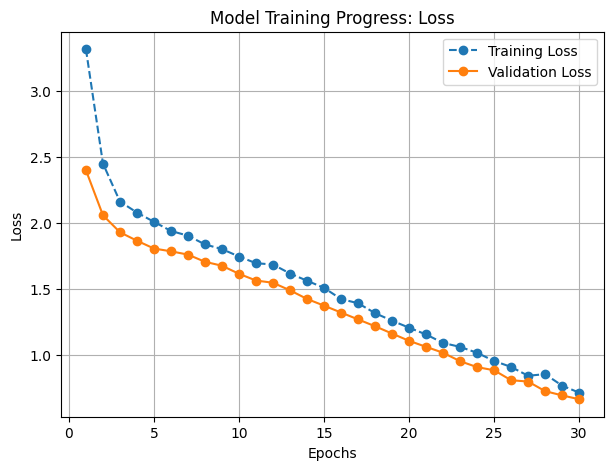

📁 Loss plot saved as: training_loss.png


In [ ]:
import matplotlib.pyplot as plt

def plot_training_loss(history, save_path="training_loss.png"):
    """Function to plot and save training loss."""

    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o', linestyle='--')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Training Progress: Loss')
    plt.legend()
    plt.grid()

    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"📁 Loss plot saved as: {save_path}")

# ✅ Call function to save and plot
plot_training_loss(history, "training_loss.png")


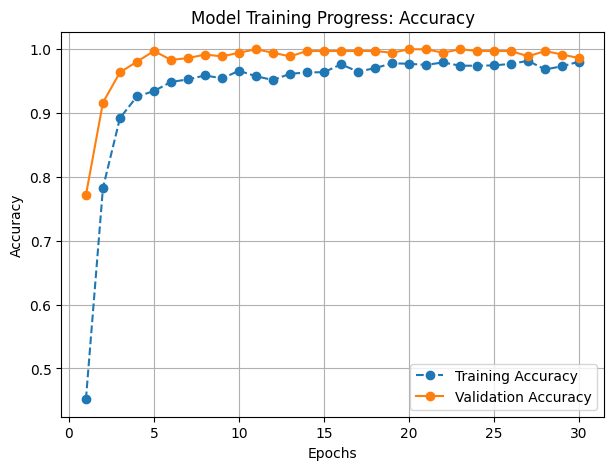

📁 Accuracy plot saved as: training_accuracy.png


In [ ]:
def plot_training_accuracy(history, save_path="training_accuracy.png"):
    """Function to plot and save training accuracy."""

    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o', linestyle='--')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Training Progress: Accuracy')
    plt.legend()
    plt.grid()

    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"📁 Accuracy plot saved as: {save_path}")

# ✅ Call function to save and plot
plot_training_accuracy(history, "training_accuracy.png")


In [ ]:
from google.colab import files
files.download("training_loss.png")
files.download("training_accuracy.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>